author: @SteveEckel

This example covers a two level, 1D optical molasses and compares results to
P. D. Lett, et. al., _J. Opt. Soc. Am. B_ __6__, 2084 (1989).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import cProfile, pstats, io
import lmfit
from pylcp.common import progressBar
plt.style.use('paper')
savefigs = False

### Let's start by defining the problem at hand:

In [2]:
delta = -1
beta = 1

# Now, make 1D laser beams:
def return_lasers(delta, beta):
    return pylcp.laserBeams([
        {'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        {'kvec':np.array([-1., 0., 0.]), 'pol':np.array([0., 1., 0.]),
         'pol_coord':'spherical', 'delta':delta, 'beta':beta},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

laserBeams = return_lasers(0., beta)

# Now define the two level Hamiltonian.  We'll connect it using pi-light.
def return_hamiltonian(delta):
    Hg = np.array([[0.]])
    He = np.array([[-delta]])
    mu_q = np.zeros((3, 1, 1))
    d_q = np.zeros((3, 1, 1))
    d_q[1, 0, 0] = 1.

    return pylcp.hamiltonian(Hg, He, mu_q, mu_q, d_q)

hamiltonian = return_hamiltonian(delta)

magField = lambda R: np.zeros(R.shape)

# Use this variable to select either a rate-equation or OBE calculation:
#obj = pylcp.rateeq
#extra_args = {}
obj = pylcp.obe
extra_args = {'progress_bar':True, 'deltat_tmax':2*np.pi*100, 'deltat_v':4,
              'itermax':1000, 'rel':1e-4, 'abs':1e-6}

eqn = obj(laserBeams, magField, hamiltonian)

### Generate the equilibrium force profile:

Completed in 21.61 s.                                                                            


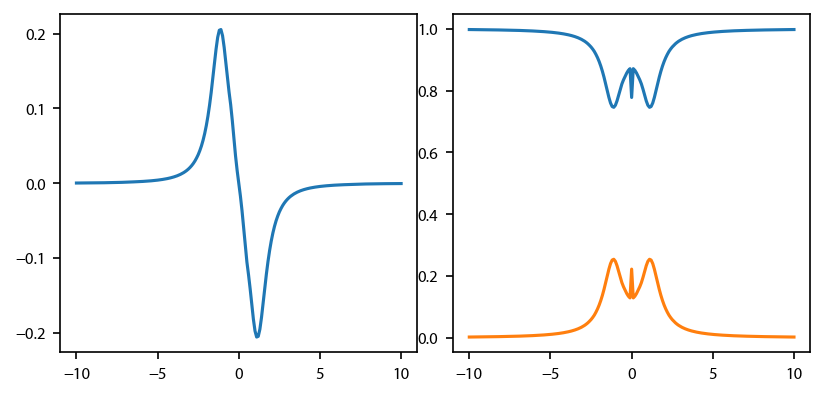

In [3]:
v = np.arange(-10., 10.1, 0.1)

eqn.generate_force_profile(np.zeros((3,) + v.shape),
                           [v, np.zeros(v.shape), np.zeros(v.shape)],
                           name='molasses', **extra_args)

fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.75))
ax[0].plot(v, eqn.profile['molasses'].F[0])
ax[1].plot(v, eqn.profile['molasses'].Neq)

### Let's next investigate the damping force
We do this as a function of beta and delta, and compare to the Lett expression for the damping

In [13]:
dv = 0.1

deltas = np.linspace(-3, 0., 101)
betas = np.array([0.01, 0.1, 1, 10])

Deltas, Betas = np.meshgrid(deltas, betas)

it = np.nditer([Deltas, Betas, None])
progress = progressBar()
for (delta, beta, alpha) in it:
    laserBeams = return_lasers(0., beta)
    hamiltonian = return_hamiltonian(delta)

    # Next, generate the OBE or rate equations:
    eqn = obj(laserBeams, magField, hamiltonian)

    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([dv, 0., 0.]))
    eqn.set_initial_rho_equally()
    alpha[...] = -eqn.find_equilibrium_force()[0][0]/dv
    progress.update((it.iterindex+1)/it.itersize)

fig, ax = plt.subplots(1, 1)
ax.plot(deltas, it.operands[2].T, linewidth=0.75)
for ii, beta in enumerate(betas):
    ax.plot(deltas, -4*beta*2*deltas/(1+2*beta+4*deltas**2)**2, '--',
             linewidth=0.75, color='C%d'%ii, label='$s=%.2f$'%beta)
ax.legend(loc='upper left')
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$\\alpha/\hbar k^2$')
if savefigs:
    fig.savefig('damping_force_rate_eq.pdf')

Progress: |██████████████████████████████----------| 75.0% complete; est. time remaining: 3:45

AttributeError: 'NoneType' object has no attribute 'rho'

### Now, we want to simulate a whole bunch of atoms
We'll run about $N_A=100$ for about $1000 \Gamma t$ to
generate some histograms and understand what velocities we obtain, etc.

Completed in 8.53 s.                                                                            


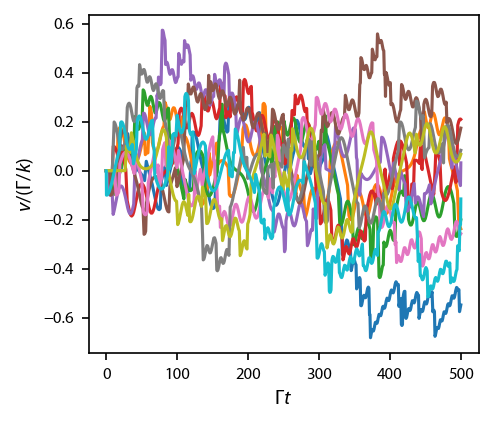

In [16]:
beta = 1.
delta = -1.

laserBeams = return_lasers(0., beta)
hamiltonian = return_hamiltonian(delta)

eqn = obj(laserBeams, magField, hamiltonian,
          transform_into_re_im=True,
          include_mag_forces=False)

vR = 0.05
N_atom = 10
v_final = np.zeros((N_atom,))
#num_of_scatters = np.zeros((N_atom,), dtype='int')
#num_of_steps = np.zeros((N_atom,), dtype='int')

fig, ax = plt.subplots(1, 1)
sols = []
progress = progressBar()
for ii in range(N_atom):
    eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]), np.array([0., 0., 0.]))
    #eqn.set_initial_pop_from_equilibrium()
    eqn.set_initial_rho_from_rateeq()

    eqn.evolve_motion([0., 500.], random_recoil=True, recoil_velocity=vR,
                      max_scatter_probability=0.5, freeze_axis=[False, True, True])
    progress.update((ii+1.)/N_atom)

    if ii<10:
        ax.plot(eqn.sol.t, eqn.sol.v[0])

    v_final[ii] = eqn.sol.v[0, -1]

    sols.append(eqn.sol)
    #num_of_scatters[ii] = sum(eqn.sol.n_random)
    #num_of_steps[ii] = len(eqn.sol.t)

ax.set_xlabel('$\Gamma t$')
ax.set_ylabel('$v/(\Gamma/k)$')
if savefigs:
    fig.savefig('first_ten_trajectories.pdf')

In [17]:
for sol in sols:
    Ne = np.array([np.real(np.diag(sol.rho[:, :, ii]))[1] for ii in range(len(sol.t))])
    print(np.sum(sol.n_random), np.mean(np.diff(sol.t)), np.amax(sol.t)*np.mean(Ne))

71 1.1764705882352942 80.9578235188048
63 1.404494382022472 65.51174309278748
73 1.3297872340425532 67.64921720853275
73 1.2594458438287153 71.81538894816008
78 1.2285012285012284 73.34935929099385
65 1.2077294685990339 71.59689647248456
63 1.272264631043257 74.35339010921643
76 1.3227513227513228 73.07323069383483
57 1.3850415512465375 64.10625217597266
92 1.1904761904761905 71.57840831101834


### Now, let's bin the final data and fit it up!

1.8064817143035188


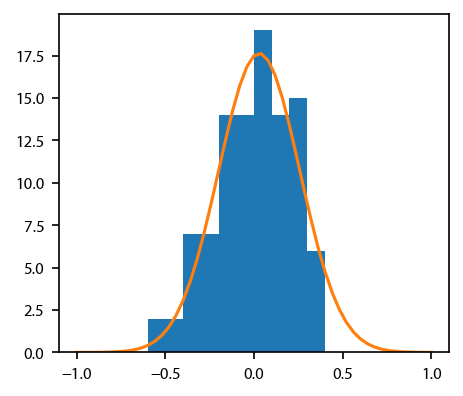

In [9]:
print(2*np.std(v_final)**2/vR)
xb = np.arange(-1., 1.1, 0.1)
fig, ax = plt.subplots(1, 1)
ax.hist(v_final, bins=xb)
x = xb[:-1] + np.diff(xb)/2
y = np.histogram(v_final, bins=xb)[0]

model = lmfit.models.GaussianModel()
result = model.fit(y, x=x)

x_fit = np.linspace(-1., 1., 51)
ax.plot(x_fit, result.eval(x=x_fit))

### Now, let's go a step further
Let's now vary the detuning and the intensity and calculate the temperature.

In [ ]:
vR = 0.05
deltas = np.array([-3, -2., -1., -0.5, -0.375, -0.25, -0.125, 0.])
betas = np.array([0.3, 1, 3])

t0 = 500 # Evolution time at delta=-1 detuning, beta=1
Deltas, Betas = np.meshgrid(deltas, betas)

it = np.nditer([Deltas, Betas, None, None])
for (delta, beta, sigma, delta_sigma) in it:
    print('Working on delta=%.1f and beta=%.1f'%(delta, beta))
    # First, generate the new laser beams and hamiltonian:
    laserBeams = return_lasers(0., beta)
    hamiltonian = return_hamiltonian(delta)

    # Next, generate the OBE or rate equations:
    eqn = obj(laserBeams, magField, hamiltonian)

    # Now, evolve however many times:
    progress = progressBar()
    for ii in range(N_atom):
        eqn.set_initial_position_and_velocity(np.array([0., 0., 0.]),
                                              np.array([0., 0., 0.]))
        eqn.set_initial_pop_from_equilibrium()
        eqn.evolve_motion([0., t0*(1+2*beta+4*np.abs(delta)**2)/7/beta],
                          random_recoil=True, recoil_velocity=vR,
                          max_scatter_probability=0.1,
                          freeze_axis=[False, True, True])

        v_final[ii] = eqn.sol.y[-6, -1]
        progress.update((ii+1.)/N_atom)

    # Now bin and fit:
    xb = np.arange(-1., 1.1, 0.1)
    x = xb[:-1] + np.diff(xb)/2
    y = np.histogram(v_final, bins=xb)[0]

    model = lmfit.models.GaussianModel()
    result = model.fit(y, x=x)

    sigma[...] = result.best_values['sigma']
    delta_sigma[...] = result.params['sigma'].stderr

    print('Got %.4f +/- %.4f'%(sigma, delta_sigma))

# time to completeion: 4 h 28 m 4s.

Plot up the results

In [ ]:
# %%
def lett_function(beta, delta):
    return 0.5*(1+2*beta+4*delta **2)/2/np.abs(delta)

deltas_thr = np.linspace(-3, -0.125, 51)
fig, ax = plt.subplots(1, 1)
for ii, (beta, sigmas, err) in enumerate(zip(betas, it.operands[2], it.operands[3])):
    plt.errorbar(deltas, 2*sigmas**2/vR, 2*sigmas*err/vR, fmt='.', color='C%d'%ii)
    plt.plot(deltas_thr, lett_function(beta, deltas_thr), linewidth=0.75, color='C%d'%ii)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$T/T_D$')
ax.set_ylim((1, 5))
if savefigs:
    fig.savefig('final_temperature_two_level_1D_molasses_rate_eqn.pdf')